# Parking with Hindsight Experience Replay

##  Warming up
We start with a few useful installs and imports:

In [1]:
#@title Install environment and agent
!pip install highway-env
# TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
!pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-ei8awdyi
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-ei8awdyi
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit 35eccaf04fa011128f02eaecac6caab535686459
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


2024-04-26 16:23:42.011731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary cache directory at /tmp/matplotlib-clc22c5i because the default path (/home/nostalgic_ramanujan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
#@title Import helpers for visualization of episodes
import sys
from tqdm.notebook import trange
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

In [5]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

In [12]:
#@title Training
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

LEARNING_STEPS = 5e4 # @param {type: "number"}

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}


env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72.8     |
|    ep_rew_mean     | -34      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 28       |
|    time_elapsed    | 10       |
|    total_timesteps | 291      |
| train/             |          |
|    actor_loss      | -5.42    |
|    critic_loss     | 0.111    |
|    ent_coef        | 0.828    |
|    ent_coef_loss   | -0.63    |
|    learning_rate   | 0.001    |
|    n_updates       | 190      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 160      |
|    ep_rew_mean     | -83.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 23       |

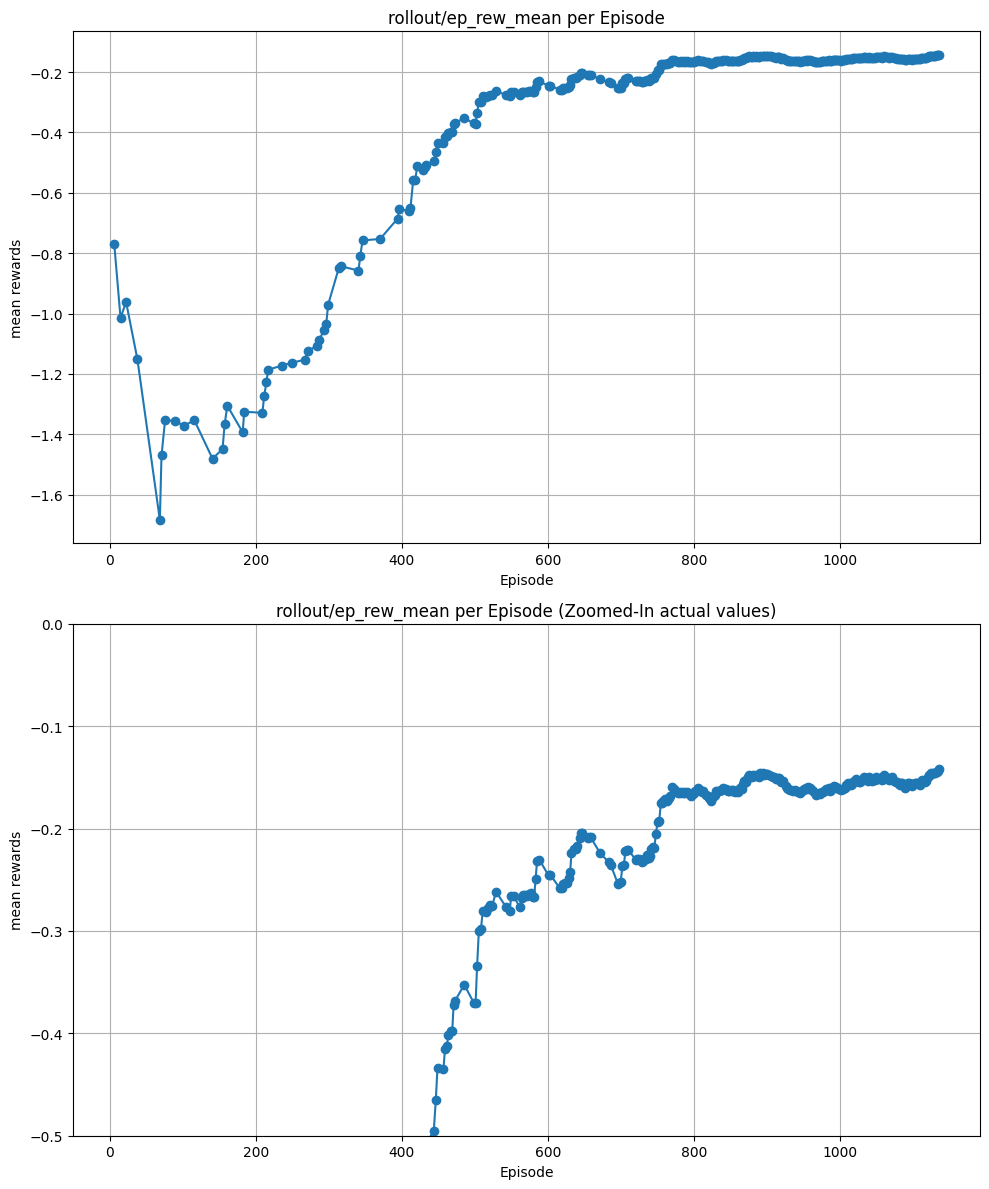

In [6]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = ""
event_file_name = "logs/SAC_1/events.out.tfevents.1714136923.468467fca88f.2750.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot) 

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 44 for event in scalar_events]
    episode_values = [event.value / 44 for event in scalar_events]

    # Create subplots with two axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the full-size figure
    ax1.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax1.set_title(f'{tag_to_plot} per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('mean rewards')
    ax1.grid(True)

    # Zoomed-in plot on y-axis
    ax2.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax2.set_title(f'{tag_to_plot} per Episode (Zoomed-In actual values)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('mean rewards')
    ax2.grid(True)
    ax2.set_ylim(-0.5, 0)  # Set y-axis limit for zoomed-in plot

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


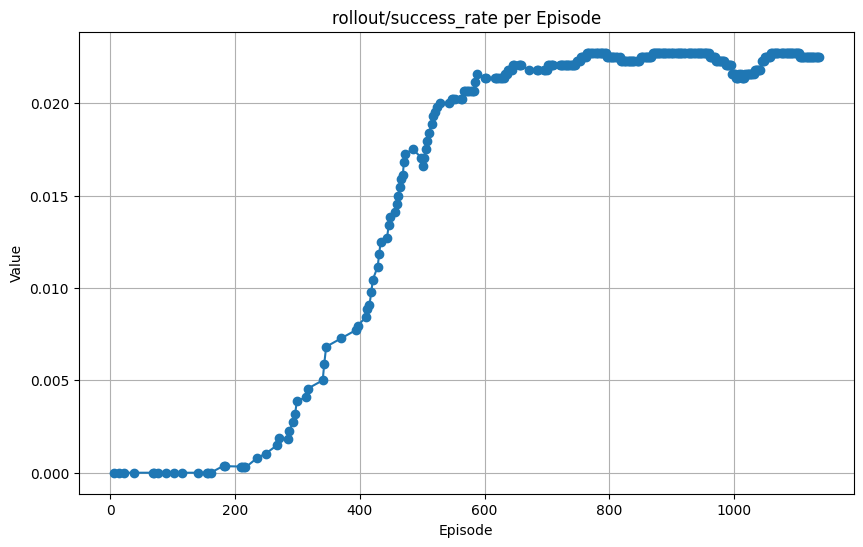

In [7]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = ""
event_file_name = "logs/SAC_1/events.out.tfevents.1714136923.468467fca88f.2750.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/44 for event in scalar_events]
    episode_values = [event.value/44 for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


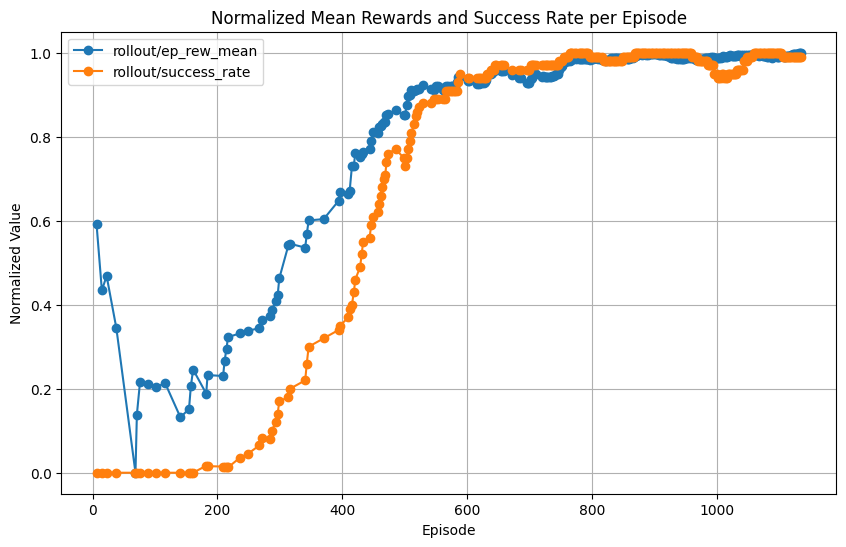

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = ""
event_file_name = "logs/SAC_1/events.out.tfevents.1714136923.468467fca88f.2750.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 44 for event in scalar_events]
        episode_values = [event.value / 44 for event in scalar_events]

        # Normalize values between 0 and 1
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot the normalized scalar value per episode
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Normalized Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


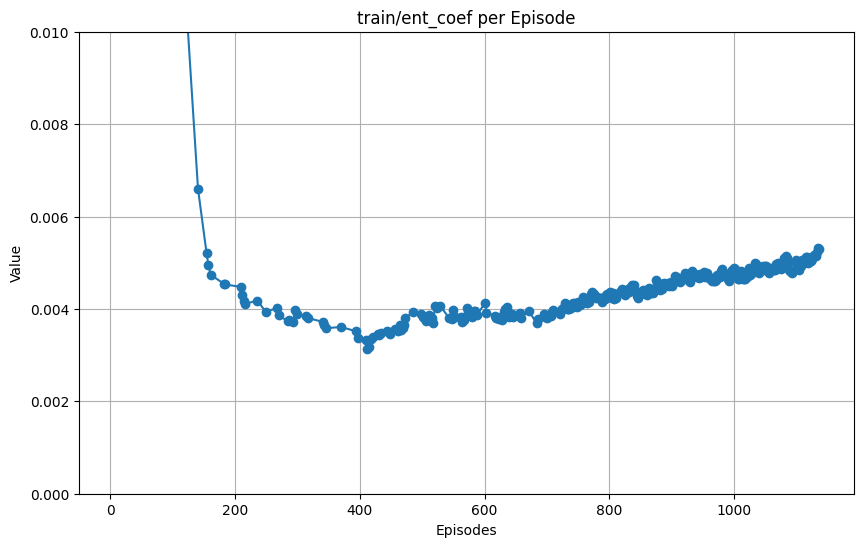

In [9]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = ""
event_file_name = "logs/SAC_1/events.out.tfevents.1714136923.468467fca88f.2750.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 44 for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(0, 0.01)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


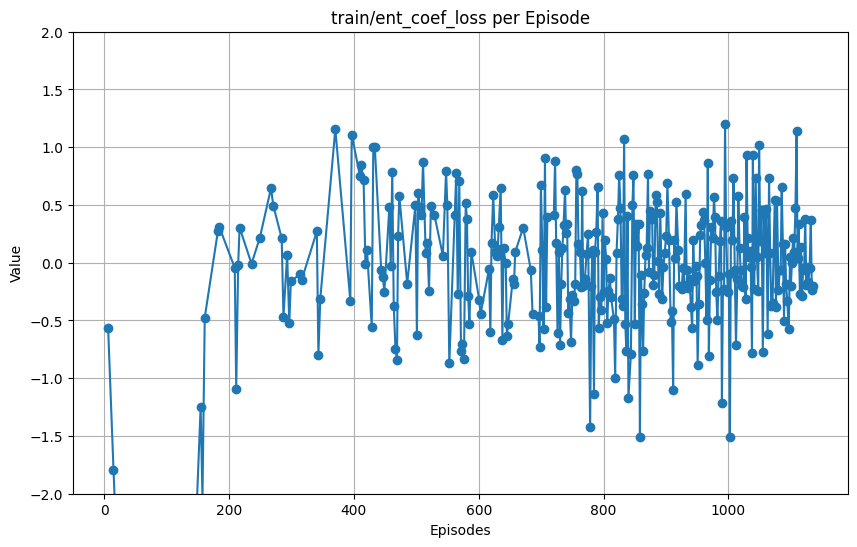

In [10]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = ""
event_file_name = "logs/SAC_1/events.out.tfevents.1714136923.468467fca88f.2750.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/44  for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(-2, 2)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


In [13]:
#@title Visualize a few episodes

N_EPISODES = 10  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  85%|████████▌ | 68/80 [00:00<00:00, 121.39it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  68%|██████▊   | 40/59 [00:00<00:00, 195.67it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t:  77%|███████▋  | 70/91 [00:00<00:00, 182.14it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  80%|████████  | 68/85 [00:00<00:00, 152.77it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t:  76%|███████▋  | 45/59 [00:00<00:00, 221.38it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  80%|████████  | 68/85 [00:00<00:00, 153.67it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  79%|███████▊  | 37/47 [00:00<00:00, 179.64it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  96%|█████████▌| 45/47 [00:00<00:00, 218.51it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  92%|█████████▏| 89/97 [00:00<00:00, 179.62it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  58%|█████▊    | 22/38 [00:00<00:00, 210.14it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4


In [ ]:
pip install moviepy